# SPAM Dataset visualization

In [1]:
from main import data_spam, load_data, preprocessing, visualize

Here we charge the dataframe from the spambase : 4600 emails with 58 features

In [2]:
_, _, df, features = load_data(data_spam)
df

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
3683,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.0,0.000,0.000,0.0,1.000,1,3,0
4411,0.71,0.00,0.71,0.0,0.00,0.00,0.00,0.00,0.00,0.71,...,0.0,0.000,0.0,0.000,0.000,0.0,1.032,2,32,0
2584,0.00,0.00,1.09,0.0,0.00,0.00,0.00,0.00,0.00,1.09,...,0.0,0.325,0.0,0.000,0.000,0.0,4.586,51,133,0
69,0.00,0.00,0.00,0.0,1.26,0.00,2.53,1.26,1.26,1.26,...,0.0,0.000,0.0,0.537,0.000,0.0,72.500,287,290,1
1844,0.00,0.00,0.75,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.262,0.0,0.000,0.000,0.0,1.437,3,23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.0,0.000,0.000,0.0,5.153,55,67,0
466,0.09,0.18,0.36,0.0,0.09,0.00,0.09,0.00,0.55,0.27,...,0.0,0.056,0.0,0.341,0.085,0.0,7.273,103,1171,1
3092,0.00,14.28,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.0,0.000,0.000,0.0,1.800,5,9,0
3772,0.00,0.00,0.00,0.0,1.23,0.00,0.00,0.00,0.00,0.00,...,0.0,0.468,0.0,0.000,0.000,0.0,1.058,2,18,0


And verify with the .info() method.

We also check that there is no missing values in each of the columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4600 entries, 3683 to 860
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              4600 non-null   float64
 1   word_freq_address           4600 non-null   float64
 2   word_freq_all               4600 non-null   float64
 3   word_freq_3d                4600 non-null   float64
 4   word_freq_our               4600 non-null   float64
 5   word_freq_over              4600 non-null   float64
 6   word_freq_remove            4600 non-null   float64
 7   word_freq_internet          4600 non-null   float64
 8   word_freq_order             4600 non-null   float64
 9   word_freq_mail              4600 non-null   float64
 10  word_freq_receive           4600 non-null   float64
 11  word_freq_will              4600 non-null   float64
 12  word_freq_people            4600 non-null   float64
 13  word_freq_report            4600 non

Using the .DOCUMENTATION file, we learn that each feature named "word_freq_*WORD*" represent the percentage of word in the email which **are** the word *WORD*. (48 features of this type)

For exemple :
- **word_freq_credit** gives the percentage of word in the email that match the word "*credit*"
- **word_freq_report** same with word "*report*"

6 features are named "char_freq_*CHAR*" which is the same as before but with a character *CHAR*.

Exemples :
- **char_freq_;**
- **char_freq_$**

The remaining columns are : 

**capital_run_length_average** = average length of uninterrupted sequences of capital letters

**capital_run_length_longest** = length of longest uninterrupted sequence of capital letters

**capital_run_length_total** = sum of length of uninterrupted sequences of capital letters = total number of capital letters in the e-mail

**is_spam** = denotes whether the e-mail was considered spam (1) or not (0),  i.e. unsolicited commercial e-mail

In [4]:
df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,Class
count,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,...,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,0.104576,0.212922,0.280578,0.065439,0.312222,0.095922,0.114233,0.105317,0.090087,0.239465,...,0.038583,0.139061,0.016980,0.268960,0.075827,0.044248,5.191827,52.170870,283.290435,0.393913
std,0.305387,1.290700,0.504170,1.395303,0.672586,0.273850,0.391480,0.401112,0.278643,0.644816,...,0.243497,0.270377,0.109406,0.815726,0.245906,0.429388,31.732891,194.912453,606.413764,0.488669
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.275500,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.382500,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.314250,0.052000,0.000000,3.705250,43.000000,265.250000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


We check the number of spam in the dataset :

In [5]:
df["Class"].value_counts()

Class
0    2788
1    1812
Name: count, dtype: int64

For some of the features we can see how the data is distributed, distinguishing spam and no spam, and the different correlations
Most of the other features have their density concentrated around 0.

2D correlation here is not quite relevent because there is a lot of superposition and datas are concentrated.
Correlation matrix is way more usefull to understand this.

In [ ]:
print(features)

visualize(data_spam, features[:5], random=False)

# Objectives

The objective of this notebook is to build and compare several Machine Learning models on the Spam dataset. We will evaluate four different approaches — K-Nearest Neighbors (KNN), a Multilayer Perceptron Neural Network (MLP), a Random Forest classifier, and a Linear Support Vector Classifier (Linear SVC). For each model, we will train, evaluate, and compare their prediction accuracies. In addition, we will analyze feature importance to better understand which variables contribute the most to the classification performance.

# Functions and Workflow Description

The preprocessing function loads the dataset, normalize the continuous features (not the binary-ones), and return a train, val, test split.
For each model, we defined it, set a train and a predict function. We train the model with the split we made in preprocessing.
Then we call the benchmark function (same for every model), which uses the predict function, and returns an accuracy report, a confusion matrix and the overall feature importance. It allows us to compare models between each other.


# K nearest neighbour


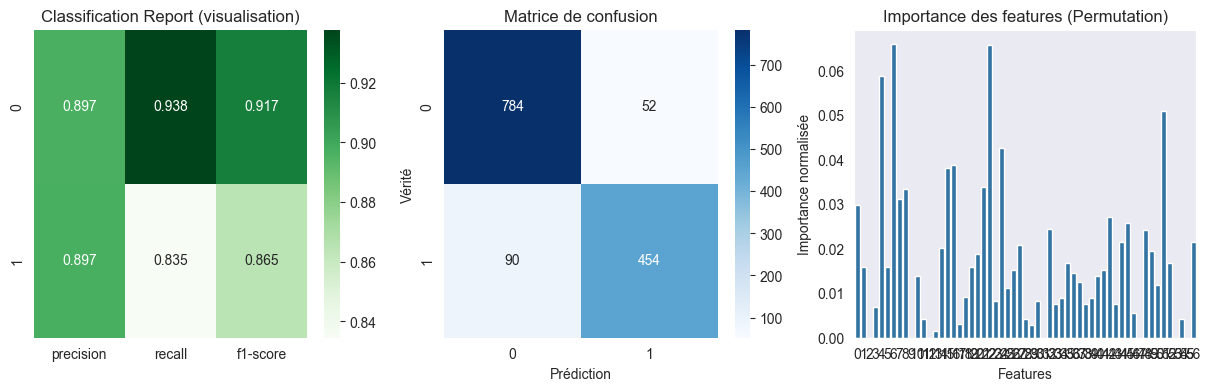

In [7]:
from main import KNNModel

samples = preprocessing(data=data_spam, test_size=0.3, validation_size=0.1)
model = KNNModel()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_test, y=samples.y_test)

## Analysis


The dataset being a bit unbalanced, what interest us, more than the overall accuracy is the recall and precision, and the f1-score which combine those two metrics. So our objective is to find a compromise between detecting as many spam messages as possible (high recall) while avoiding misclassifying legitimate emails as spam (high precision), which is exactly what the F1-score helps us evaluate.

As we can see here with the classification report, a quite simple model such as KNN (K=3) as very good performances. Considering the spam problem, our goal can be not to miss any spam e-mails, so maximize the recall for class 1. Here this is the metric with the less percentage (83,5%) compare to non-spam recall.

Next we would like to equilibrate these two recall and maximize them, without influencing the overall precision.

Let's do feature selection with the 6 most important features (more than 0.04%) to see what happens

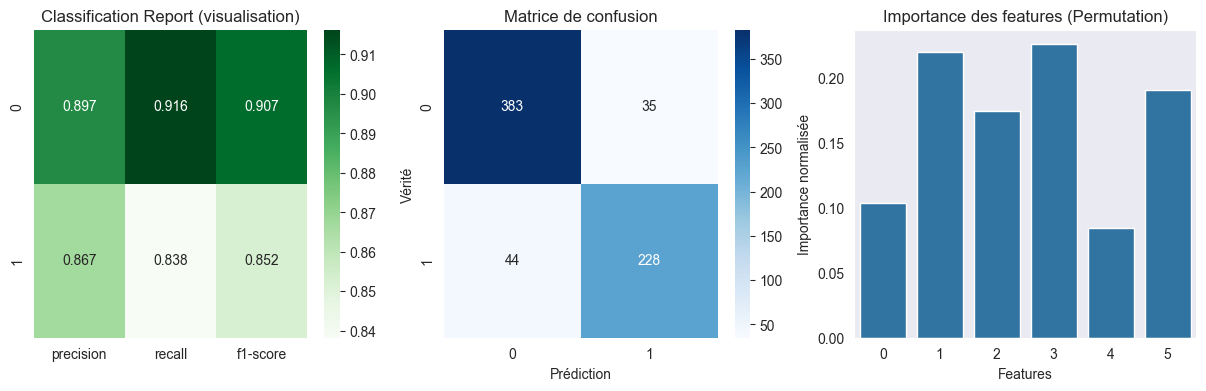

In [8]:
samples = preprocessing(data=data_spam, test_size=0.15, validation_size=0.15)

cols = [4, 6, 15, 22, 44, 51]
samples.X_train = samples.X_train[:, cols]
samples.X_test = samples.X_test[:, cols]
samples.X_validation = samples.X_validation[:, cols]

model = KNNModel()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_test, y=samples.y_test)

There isn't any improvement in the model but the training and prediction is much faster.

In [10]:
from main import MLPModel

samples = preprocessing(data=data_spam, test_size=0.15, validation_size=0.15)
model = MLPModel(input_size=57, epochs=30)
model.train(samples)

epoch: 1 	training Loss: 1.077077 
Validation loss improved → new best = 1.014940
epoch: 2 	training Loss: 0.971518 
Validation loss improved → new best = 0.865268
epoch: 3 	training Loss: 0.818781 
Validation loss improved → new best = 0.677181
epoch: 4 	training Loss: 0.632150 
Validation loss improved → new best = 0.511616
epoch: 5 	training Loss: 0.502013 
Validation loss improved → new best = 0.423556
epoch: 6 	training Loss: 0.442085 
Validation loss improved → new best = 0.403866
epoch: 7 	training Loss: 0.421184 
Validation loss improved → new best = 0.383422
epoch: 8 	training Loss: 0.382337 
Validation loss improved → new best = 0.375672
epoch: 9 	training Loss: 0.349808 
Validation loss improved → new best = 0.363735
epoch: 10 	training Loss: 0.329278 
Validation loss improved → new best = 0.362329
epoch: 11 	training Loss: 0.322828 
Validation loss improved → new best = 0.358883
epoch: 12 	training Loss: 0.312117 
Validation loss improved → new best = 0.357568
epoch: 13 	tr

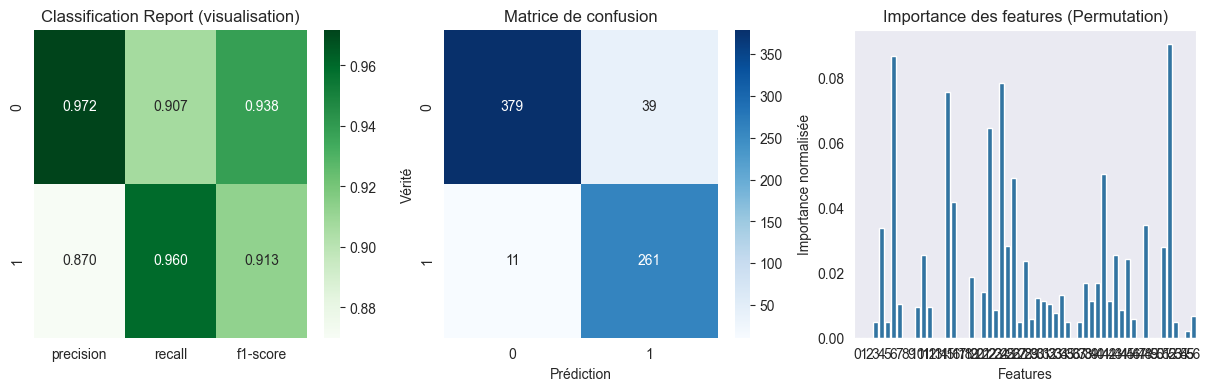

In [11]:
model.benchmark(samples.X_test, samples.y_test)

# Analysis

Here, we implement a simple Neural Network—an MLP with three hidden layers and 10 units per layer. The model is trained for a total of 30 epochs. We observed that beyond 25 epochs, the validation loss barely improves, which makes this training duration a reasonable choice.

Compared to KNN, the results are significantly better: the precision for the positive (spam) class remains around 87% (–2 pts), but the recall increases to 96% (+13.5 pts). This means that the model successfully identifies 96% of spam emails, which is a very strong result. Even though the classifier may incorrectly label some legitimate emails as spam, this type of error has limited consequences.

A key advantage is that we improved the most critical metric (recall) without severely compromising the others. Additionally, we can tune the decision threshold applied to the MLP’s probabilistic output. Since the model outputs a probability between 0 and 1, we arbitrarily classify values above 0.5 as spam and below 0.5 as non-spam. Adjusting this threshold allows us to control the trade-off between precision and recall depending on the application’s requirements.

We also noticed that the accuracy can vary by up to 2% across training runs, likely due to differences in the model’s random initialization. A potential improvement would be to optimize or stabilize this initialization step in order to achieve more consistent performance.

Let's do feature selection with the 6 most important features (more than 0.04%) to see what happens

In [12]:
samples = preprocessing(data=data_spam, test_size=0.15, validation_size=0.15)

cols = [6, 24, 26, 45, 52, 55]
samples.X_train = samples.X_train[:, cols]
samples.X_test = samples.X_test[:, cols]
samples.X_validation = samples.X_validation[:, cols]


model = MLPModel(input_size=6, epochs=100)
model.train(samples)

epoch: 1 	training Loss: 1.063214 
Validation loss improved → new best = 0.975286
epoch: 2 	training Loss: 0.928571 
Validation loss improved → new best = 0.793330
epoch: 3 	training Loss: 0.772590 
Validation loss improved → new best = 0.632268
epoch: 4 	training Loss: 0.632018 
Validation loss improved → new best = 0.536381
epoch: 5 	training Loss: 0.555777 
Validation loss improved → new best = 0.495443
epoch: 6 	training Loss: 0.527606 
Validation loss improved → new best = 0.485181
epoch: 7 	training Loss: 0.522905 
Validation loss improved → new best = 0.469861
epoch: 8 	training Loss: 0.519523 
Validation loss improved → new best = 0.461278
epoch: 9 	training Loss: 0.516423 
Validation loss improved → new best = 0.460899
epoch: 10 	training Loss: 0.507397 
Validation loss improved → new best = 0.458533
epoch: 11 	training Loss: 0.485477 
Validation loss improved → new best = 0.457412
epoch: 12 	training Loss: 0.492758 
Validation loss improved → new best = 0.455583
epoch: 13 	tr

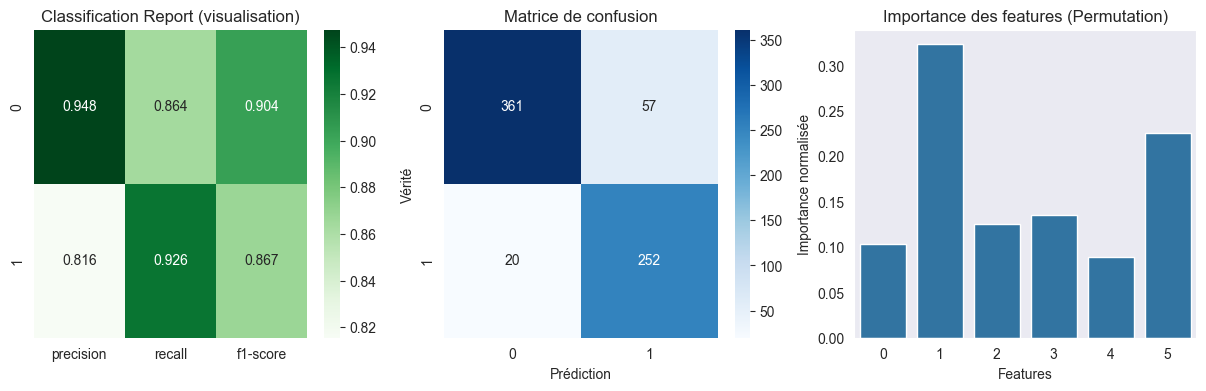

In [13]:
model.benchmark(samples.X_test, samples.y_test)

Using only 6 features for spam classification reduces the model’s performance.
With such a limited number of features, the model has less information to separate spam from non-spam, which makes learning harder. Consequently, the loss decreases more slowly during training, requiring more epochs, and even then, it does not reach the same minimum loss as when using the full set of features.

We decide not to do feature selection anymore as the performance are quite good for this dataset.

# Random Forest

In [14]:
from main import RForest

samples = preprocessing(data=data_spam, test_size=0.3, validation_size=0.1)
model = RForest()
model.train(x=samples.X_train, y=samples.y_train)

Best hyperparameters found with Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}


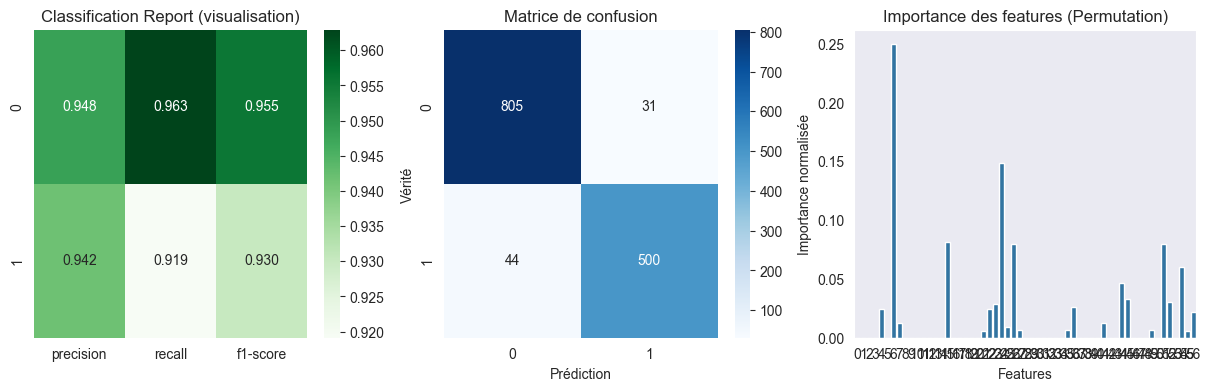

In [15]:
model.benchmark(x=samples.X_test, y=samples.y_test)

# Analysis

Surprisingly, the Random Forest achieves the best overall performance among all the models we tested. However, if we focus specifically on correctly identifying spam messages, it remains slightly less effective than the MLP (–4 points in recall).

Another surprising observation is that the Random Forest relies heavily on the 7th feature (word_freq_remove). While this feature was also important for the other models, it becomes dominant here, accounting for nearly 30% of the total feature importance—far more than in the other classifiers.

A plausible explanation for the strong performance of the Random Forest is that decision-tree–based models excel at capturing nonlinear interactions and threshold-based patterns in the data. The spam dataset contains many frequency-based features that behave in a piecewise manner (e.g., presence or absence of certain keywords, sudden increases in word frequency). Random Forests are particularly good at exploiting such structures, allowing them to build diverse trees that capture different aspects of the data. Additionally, their ensemble nature reduces overfitting while improving robustness, which likely contributes to their high overall accuracy.

# Linear SVC

In [16]:
from main import LinearSVC_

samples = preprocessing(data=data_spam, test_size=0.3, validation_size=0.1)
model = LinearSVC_()
model.train(x=samples.X_train, y=samples.y_train)

Best hyperparameters found with Grid Search: {'C': 1}


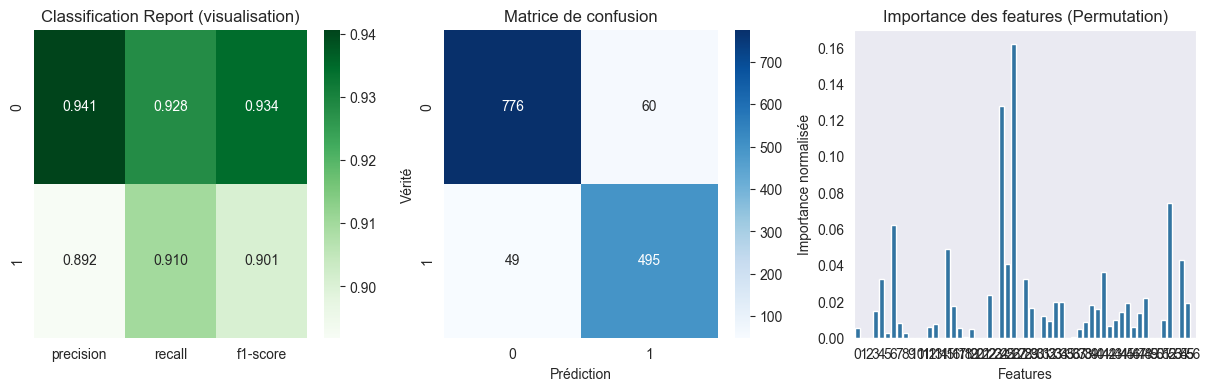

In [17]:
model.benchmark(x=samples.X_test, y=samples.y_test)

# Conclusion

For the spam classification problem, the Random Forest achieves the best overall performance, while the MLP slightly outperforms it in detecting spam emails (class 1). The models generally rely on specific key features, such as word_freq_remove, which strongly influence the predictions. Overall, both the Random Forest and the MLP are suitable choices. The optimal model ultimately depends on the objective: whether we want to catch all spam messages, even if it means misclassifying some legitimate emails (e.g., for children, phishing, etc.), or whether we prefer to maximize spam detection while keeping legitimate emails untouched to avoid missing important messages. Additionally, we can further adjust the decision threshold to fine-tune the trade-off between precision and recall for spam detection.